In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.tsa.arima.model as arima
from statsmodels.tsa.ar_model import AutoReg

In [267]:
df = pd.read_csv("merged_data.csv")

In [269]:
df.groupby("name").size()

name
fra-maeberenice_meite     8
ita-carolina_kostner     14
jpn-akiko_suzuki         13
jpn-mao_asada            13
kor-yuna_kim              6
rus-adelina_sotnikova     6
rus-julia_lipnitskaia     5
usa-ashley_wagner         8
usa-gracie_gold           4
usa-polina_edmunds        3
dtype: int64

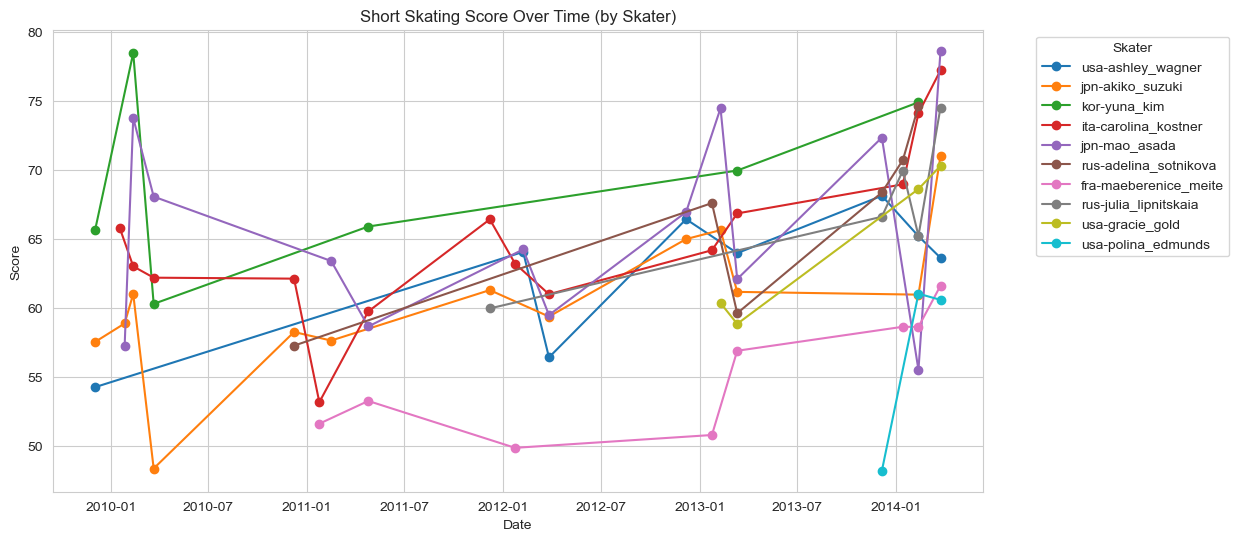

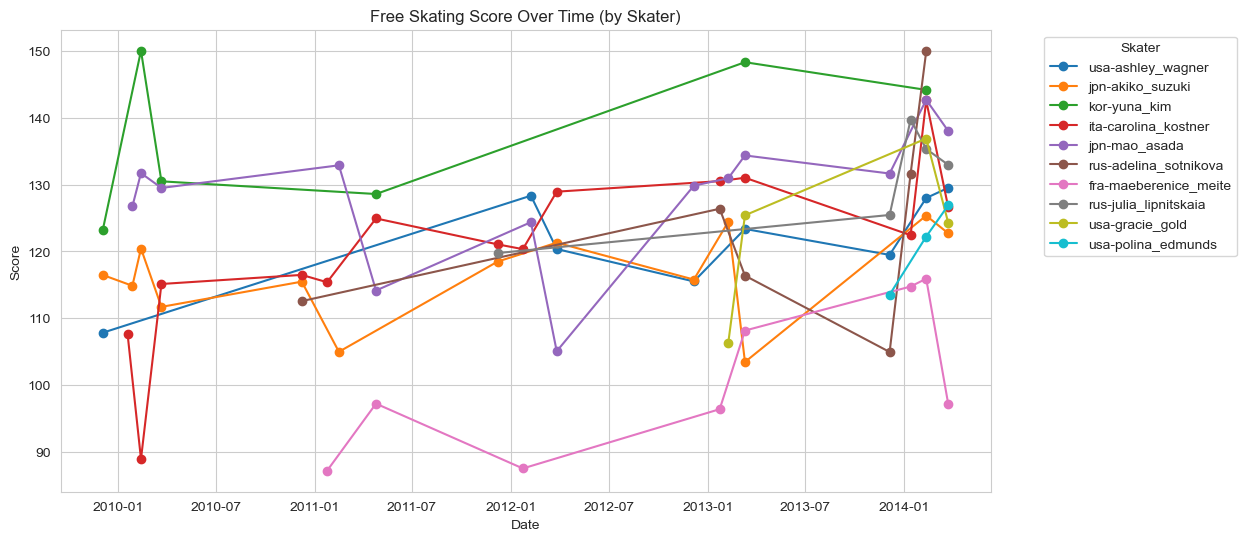

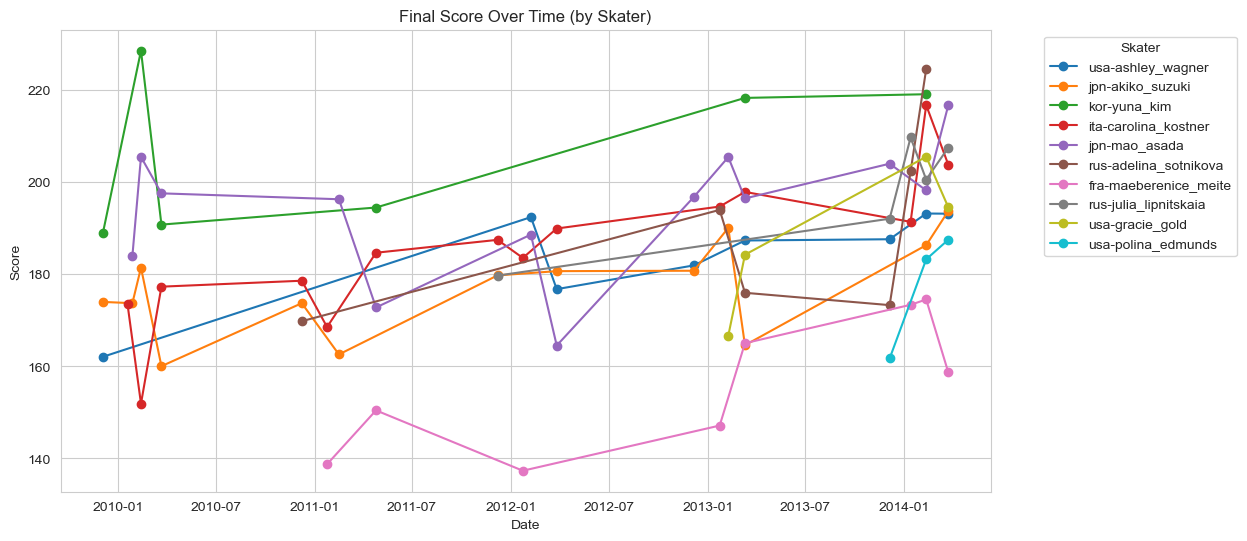

In [271]:
# 날짜를 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'])

# 선수 목록 가져오기
players = df['name'].unique()

# 점수 유형
score_types = ['short-score', 'free-score', 'final-score']
titles = ['Short Skating Score', 'Free Skating Score', 'Final Score']

# 그래프 그리기
for score_type, title in zip(score_types, titles):
    plt.figure(figsize=(12, 6))

    for player in players:
        player_data = df[df['name'] == player]
        plt.plot(player_data['date'], player_data[score_type], marker='o', label=player)

    plt.title(f"{title} Over Time (by Skater)")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.legend(title="Skater", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

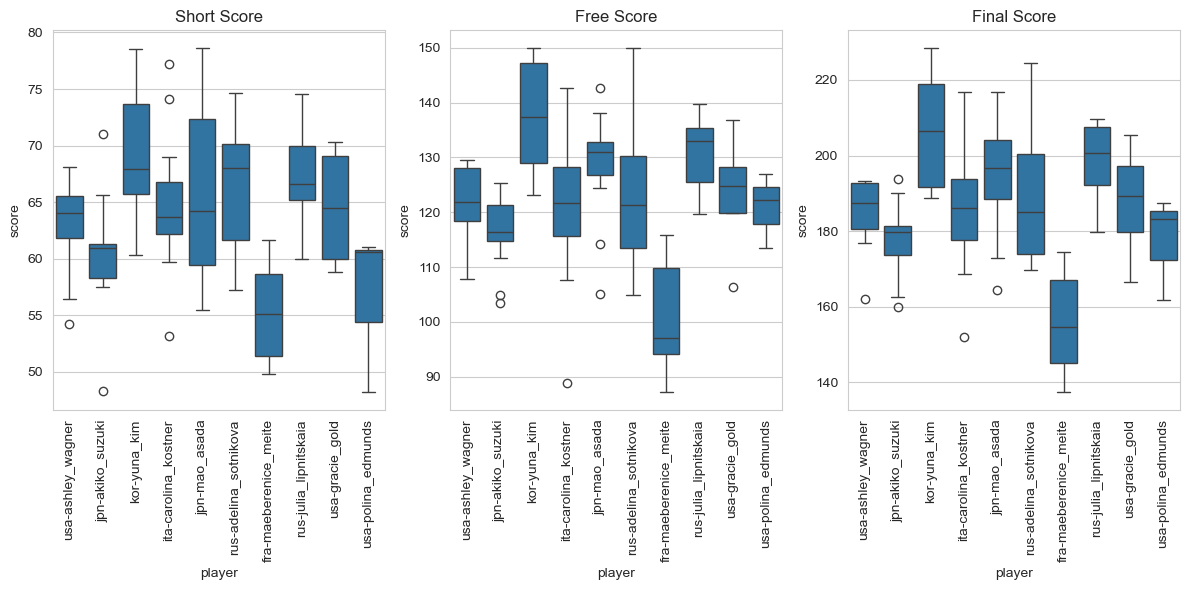

In [272]:
# 선수별 점수 데이터만 추출
score_columns = ['short-score', 'free-score', 'final-score']
df_scores = df[['name'] + score_columns]

# 데이터를 long format으로 변환
df_melted = df_scores.melt(id_vars=['name'], var_name='n', value_name='score')

# 그래프 설정
plt.figure(figsize=(12, 6))

# 종목별 boxplot 그리기
for i, event in enumerate(score_columns, 1):
    plt.subplot(1, 3, i)  # 1행 3열의 서브플롯 중 i번째
    sns.boxplot(x='name', y='score', data=df_melted[df_melted['n'] == event])
    plt.xticks(rotation=90)  # 선수 이름 가독성을 위해 회전
    plt.title(event.replace("-", " ").title())  # 제목 설정
    plt.xlabel("player")  # x축 라벨
    plt.ylabel("score")  # y축 라벨

# 레이아웃 조정 후 출력
plt.tight_layout()
plt.show()

In [273]:
# 2010년 올림픽 데이터는 유지하고 2014년 올림픽 데이터만 예측 대상으로 설정
df_train = df[(df["event-title"] != "Olympics") | (df["date"] < "2014-01-01")]

# 2014년 올림픽 출전 선수들의 데이터 확보
df_2014_olympic = df[(df["event-title"] == "Olympics") & (df["date"] >= "2014-01-01")]
olympic_2014_players = df_2014_olympic["name"].unique()

# 예측을 위한 결과 저장 딕셔너리 초기화
forecast_results_filtered = {}
metrics = {}

for player in olympic_2014_players:
    player_data = df_train[df_train["name"] == player].sort_values("date").dropna()

    # 데이터 개수 제한을 완화하여 2개 이상이면 예측 수행
    if len(player_data) < 2:
        continue

    for score_type in ["short-score", "free-score"]:
        y = player_data[score_type].dropna()

        # Holt-Winters 지수 평활법 모델 적용
        hw_model = ExponentialSmoothing(y, trend="add", seasonal=None).fit()
        hw_forecast = hw_model.forecast(steps=1).values[0]
        
        arima_forecast = None
        arima_mae = arima_mse = arima_rmse = None
        
        if len(y) >= 3:
            try:
                arima_model = ARIMA(y, order=(1, 0, 0)).fit()
                arima_forecast = arima_model.forecast(steps=1).values[0]
                arima_mse = mean_squared_error(y, arima_model.fittedvalues)
                arima_rmse = np.sqrt(arima_mse)
            except:
                pass

        # 2014년 올림픽 데이터 확인
        olympic_data = df_2014_olympic[df_2014_olympic["name"] == player]

        if not olympic_data.empty:
            actual_score = olympic_data[score_type].values[0]

            # 표준 편차 계산 후 정규분포 기반 95% 신뢰구간 설정
            std_dev = np.std(y)
            lower_bound = hw_forecast - 1.96 * std_dev
            upper_bound = hw_forecast + 1.96 * std_dev

            # 모델 적합도 평가
            hw_mse = mean_squared_error(y, hw_model.fittedvalues)
            hw_rmse = np.sqrt(hw_mse)

            # 결과 저장 (ARIMA 적용이 안 되더라도 Holt-Winters 결과 포함)
            forecast_results_filtered[(player, score_type)] = {
                "HW_predicted": hw_forecast,
                "ARIMA_predicted": arima_forecast,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound,
                "actual": actual_score,
                "outlier": actual_score < lower_bound or actual_score > upper_bound
            }
            
            metrics[(player, score_type)] = {
                "HW_MSE": hw_mse, "HW_RMSE": hw_rmse,
                "ARIMA_MSE": arima_mse, "ARIMA_RMSE": arima_rmse
            }

# 모델 적합도 평가 결과 출력
pd.DataFrame.from_dict(metrics, orient='index')

C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self.

HW_MSE    HW_RMSE  ARIMA_MSE  \
fra-maeberenice_meite short-score  6.812498e+00   2.610076  10.634904   
                      free-score   5.042984e+01   7.101397  80.895117   
usa-polina_edmunds    short-score  5.881424e-09   0.000077        NaN   
                      free-score   3.811766e-10   0.000020        NaN   
jpn-akiko_suzuki      short-score  1.528295e+01   3.909342  26.457776   
                      free-score   3.888166e+01   6.235516  29.097258   
usa-ashley_wagner     short-score  1.278114e+01   3.575072  22.107917   
                      free-score   3.534349e+01   5.945039  42.863383   
jpn-mao_asada         short-score  3.475267e+01   5.895139  44.343411   
                      free-score   7.363294e+01   8.580964  76.978717   
rus-julia_lipnitskaia short-score  5.220575e-01   0.722535  27.134185   
                      free-score   2.076871e+01   4.557270  55.767492   
usa-gracie_gold       short-score  9.345606e+00   3.057058  20.897070   
                      free-score   2.273627e+01   4.768257  75.996307   
ita-carolina_kostner  short-score  2.074288e+01   4.554436  20.234062   
                      free-score   4.882604e+01   6.987563  86.509421   
kor-yuna_kim          short-score  3.635873e+01   6.029820  27.075461   
                      free-score   1.031373e+02  10.155654  78.001739   
rus-adelina_sotnikova short-score  1.254133e+01   3.541375  26.065736   
                      free-score   8.619266e+01   9.284000  58.340762   

                                   ARIMA_RMSE  
fra-maeberenice_meite short-score    3.261120  
                      free-score     8.994171  
usa-polina_edmunds    short-score         NaN  
                      free-score          NaN  
jpn-akiko_suzuki      short-score    5.143712  
                      free-score     5.394187  
usa-ashley_wagner     short-score    4.701906  
                      free-score     6.547013  
jpn-mao_asada         short-score    6.659085  
                      free-score     8.773752  
rus-julia_lipnitskaia short-score    5.209048  
                      free-score     7.467764  
usa-gracie_gold       short-score    4.571331  
                      free-score     8.717586  
ita-carolina_kostner  short-score    4.498229  
                      free-score     9.301044  
kor-yuna_kim          short-score    5.203409  
                      free-score     8.831859  
rus-adelina_sotnikova short-score    5.105461  
                      free-score     7.638112

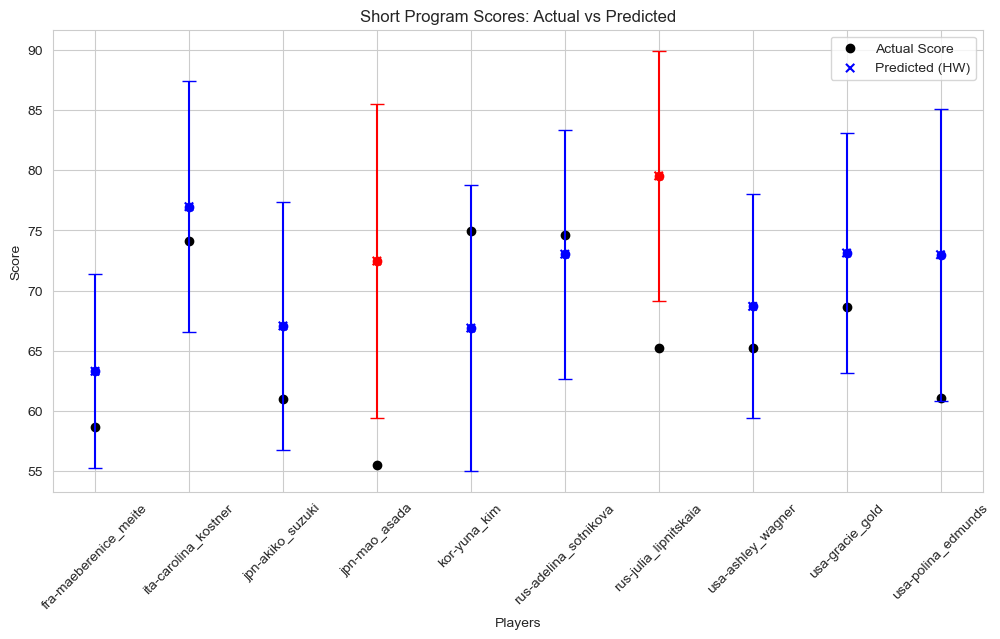

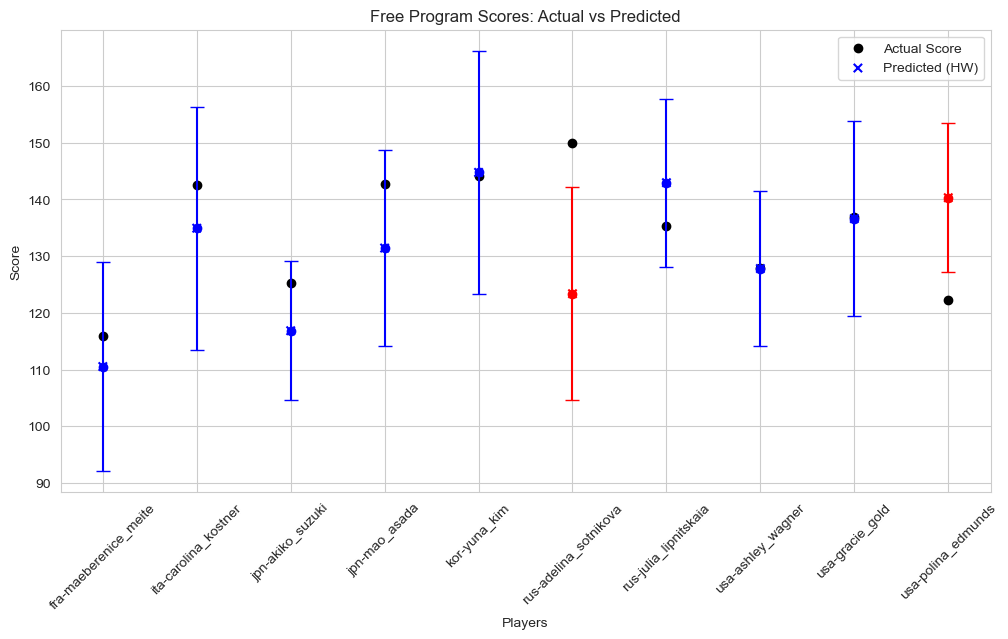

In [274]:
def plot_predictions(forecast_results_filtered, score_type, title):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    plt.title(title)

    players = list(set(player for (player, s_type) in forecast_results_filtered.keys() if s_type == score_type))
    players.sort()

    actual_scores = [forecast_results_filtered[(player, score_type)]["actual"] for player in players]
    predicted_scores = [forecast_results_filtered[(player, score_type)]["HW_predicted"] for player in players]
    lower_bounds = [forecast_results_filtered[(player, score_type)]["lower_bound"] for player in players]
    upper_bounds = [forecast_results_filtered[(player, score_type)]["upper_bound"] for player in players]
    outliers = [forecast_results_filtered[(player, score_type)]["outlier"] for player in players]

    colors = ["red" if outlier else "blue" for outlier in outliers]

    plt.scatter(players, actual_scores, color="black", marker='o', label="Actual Score")
    plt.scatter(players, predicted_scores, c=colors, marker='x', label="Predicted (HW)")

    # 개별적으로 색상 적용
    for i, (player, pred, low, up, color) in enumerate(zip(players, predicted_scores, lower_bounds, upper_bounds, colors)):
        plt.errorbar(player, pred, yerr=[[pred - low], [up - pred]], fmt='o', capsize=5, color=color)

    plt.xticks(rotation=45)
    plt.xlabel("Players")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

# 쇼트 점수 시각화
plot_predictions(forecast_results_filtered, "short-score", "Short Program Scores: Actual vs Predicted")

# 프리 점수 시각화
plot_predictions(forecast_results_filtered, "free-score", "Free Program Scores: Actual vs Predicted")

In [275]:
df.head()

,name,event-title,date,short-score,free-score,final-score,short-PCS,free-PCS
0,usa-ashley_wagner,GPF,2009-12-03,54.26,107.81,162.07,26.96,51.84
1,jpn-akiko_suzuki,GPF,2009-12-03,57.54,116.46,174.00,27.48,52.88
2,kor-yuna_kim,GPF,2009-12-03,65.64,123.22,188.86,31.84,61.52
3,ita-carolina_kostner,Europeans,2010-01-18,65.80,107.66,173.46,29.80,59.44
4,jpn-akiko_suzuki,4CC,2010-01-27,58.88,114.84,173.72,25.48,52.64


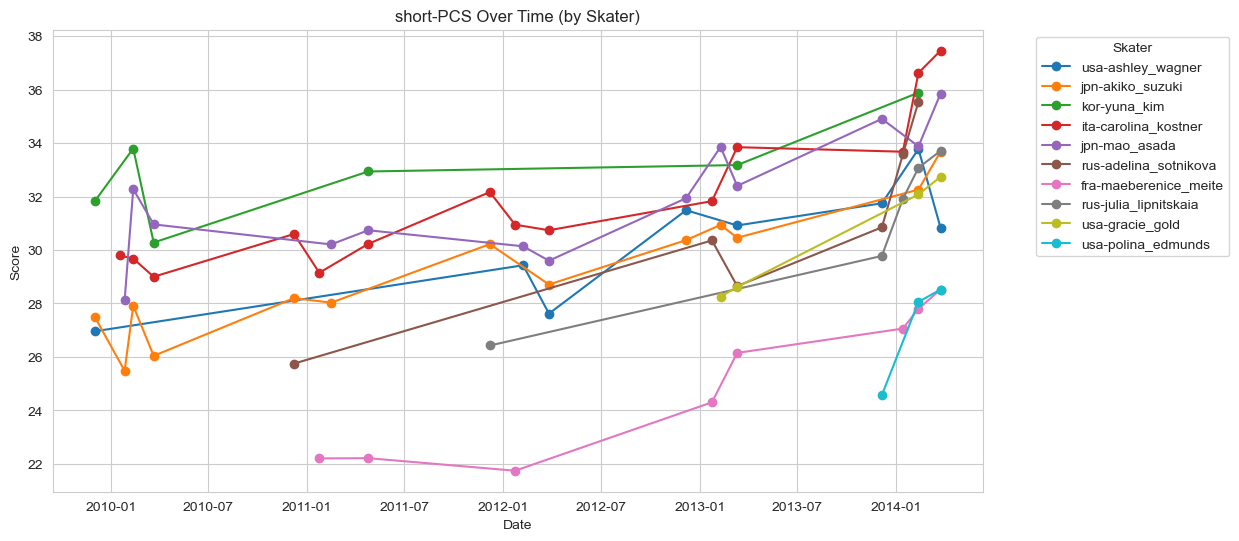

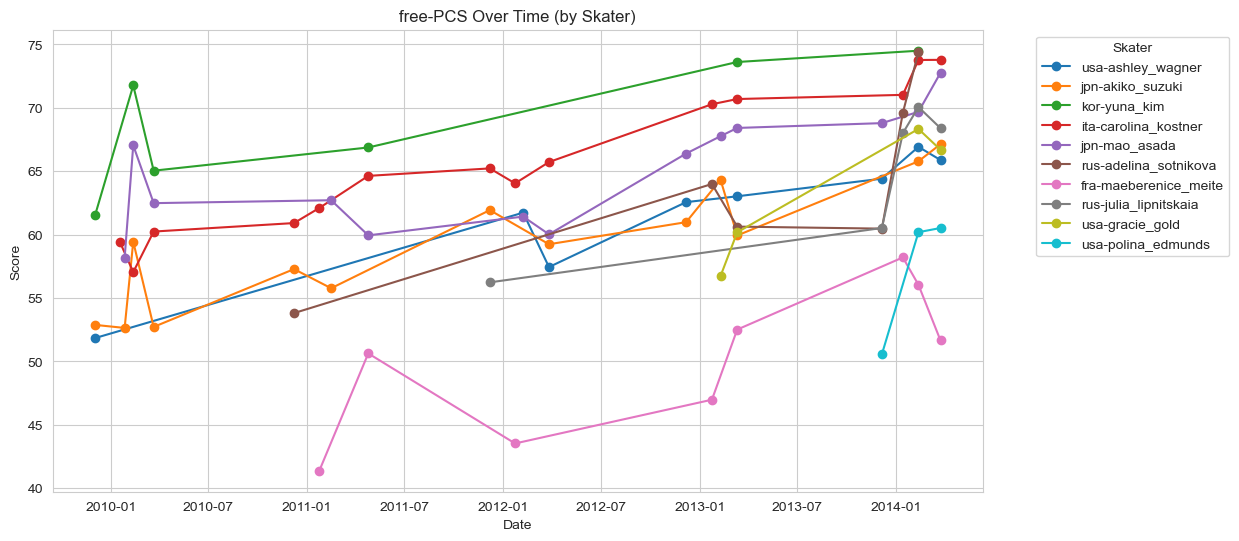

In [276]:
# 구성점수로 위의 과정 다시 해보기
# 선수 목록 가져오기
players = df['name'].unique()

# 점수 유형
score_types = ['short-PCS', 'free-PCS']
titles = ['short-PCS', 'free-PCS']

# 그래프 그리기
for score_type, title in zip(score_types, titles):
    plt.figure(figsize=(12, 6))

    for player in players:
        player_data = df[df['name'] == player]
        plt.plot(player_data['date'], player_data[score_type], marker='o', label=player)

    plt.title(f"{title} Over Time (by Skater)")
    plt.xlabel("Date")
    plt.ylabel("Score")
    plt.legend(title="Skater", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

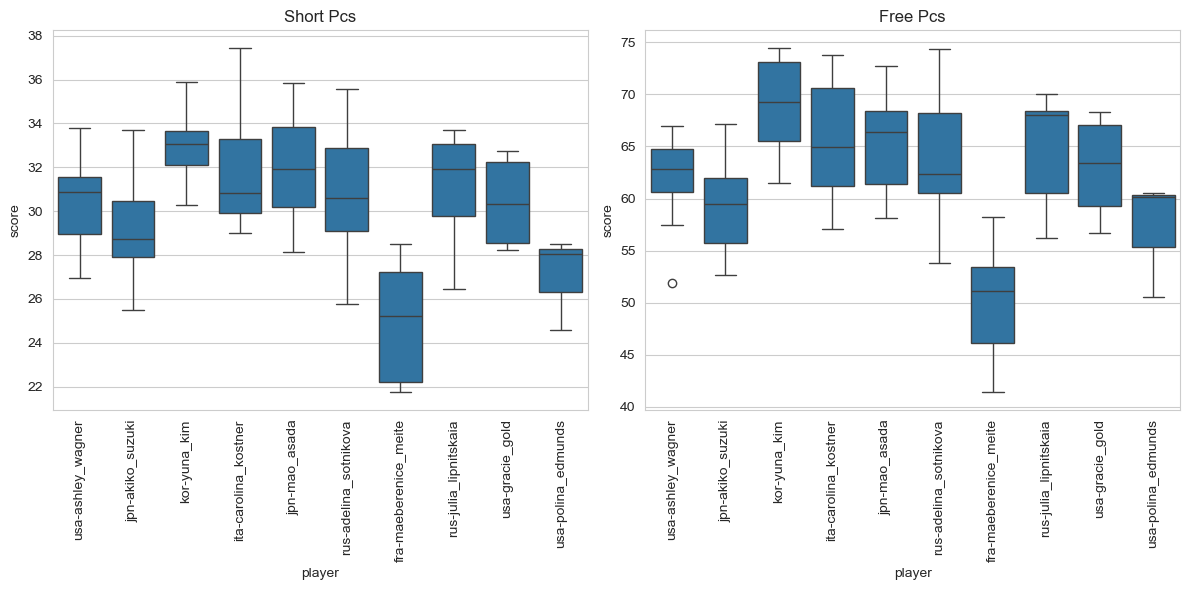

In [278]:
# 선수별 점수 데이터만 추출
score_columns = ['short-PCS', 'free-PCS']
df_scores = df[['name'] + score_columns]

# 데이터를 long format으로 변환
df_melted = df_scores.melt(id_vars=['name'], var_name='n', value_name='score')

# 그래프 설정
plt.figure(figsize=(12, 6))

# 종목별 boxplot 그리기
for i, event in enumerate(score_columns, 1):
    plt.subplot(1, 2, i)  # 1행 3열의 서브플롯 중 i번째
    sns.boxplot(x='name', y='score', data=df_melted[df_melted['n'] == event])
    plt.xticks(rotation=90)  # 선수 이름 가독성을 위해 회전
    plt.title(event.replace("-", " ").title())  # 제목 설정
    plt.xlabel("player")  # x축 라벨
    plt.ylabel("score")  # y축 라벨

# 레이아웃 조정 후 출력
plt.tight_layout()
plt.show()

In [301]:
# 2014년 소치올림픽(Olympics) 데이터 필터링
sochi_df = df[(df['date'].dt.year == 2014) & (df['event-title'].str.lower() == 'olympics')]

# 나머지 데이터를 훈련 데이터로 사용
train_df = df[df['date'] < '2014-01-01']

# 수정된 ARIMA(1,1,0) 모델 예측 코드
def fit_arima_and_predict(player_name, train_df, sochi_df):
    player_train = train_df[train_df['name'] == player_name].sort_values(by="date")
    player_sochi = sochi_df[sochi_df['name'] == player_name]

    if player_train.shape[0] < 3 or player_sochi.empty:
        return None  # 최소 3개 이상의 데이터가 없으면 제외

    results = {}
    for score_type in ['short-PCS', 'free-PCS']:
        y = player_train[score_type].values
        if len(y) < 3:
            continue  # 데이터 부족 시 건너뜀

        # ARIMA(1,1,0) 모델 적합
        model = arima.ARIMA(y, order=(1, 1, 0)).fit()
        predicted_value = model.forecast(steps=1)[0]  # .iloc 제거

        # 신뢰구간 계산
        forecast_result = model.get_forecast(steps=1)
        conf_int = forecast_result.conf_int().flatten()  # to_numpy() 제거

        # 신뢰구간 값 확인 후 처리
        if len(conf_int) == 2:
            lower_bound, upper_bound = conf_int
        else:
            lower_bound, upper_bound = np.nan, np.nan  # 신뢰구간이 없으면 NaN 처리

        # 실제 값
        actual_value = player_sochi[score_type].values[0] if not player_sochi.empty else None

        results[score_type] = {
            "predicted": predicted_value,
            "actual": actual_value,
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
            "error": abs(predicted_value - actual_value) if actual_value is not None else np.nan
        }

    return results

# 선수별 예측 수행
predictions = {}
for player in train_df['name'].unique():
    result = fit_arima_and_predict(player, train_df, sochi_df)
    if result:
        predictions[player] = result

# 결과를 데이터프레임으로 정리
prediction_df = pd.DataFrame([
    {"name": player, "score_type": score_type, **info}
    for player, results in predictions.items()
    for score_type, info in results.items()
])

# 예측 결과 확인
prediction_df

,name,score_type,predicted,actual,lower_bound,upper_bound,error
0,usa-ashley_wagner,short-PCS,31.246537,33.78,27.848206,34.644869,2.533463
1,usa-ashley_wagner,free-PCS,63.357422,66.92,55.651337,71.063508,3.562578
2,jpn-akiko_suzuki,short-PCS,30.804190,32.26,28.548092,33.060287,1.455810
3,jpn-akiko_suzuki,free-PCS,62.778656,65.78,56.420473,69.136839,3.001344
4,kor-yuna_kim,short-PCS,33.025644,35.89,29.728492,36.322795,2.864356
5,kor-yuna_kim,free-PCS,69.201479,74.50,58.046426,80.356531,5.298521
6,ita-carolina_kostner,short-PCS,33.440172,36.63,30.945148,35.935196,3.189828
7,ita-carolina_kostner,free-PCS,70.745547,73.77,66.415731,75.075364,3.024453
8,jpn-mao_asada,short-PCS,33.818666,33.88,30.214647,37.422684,0.061334
9,jpn-mao_asada,free-PCS,68.595486,69.68,61.643651,75.547321,1.084514


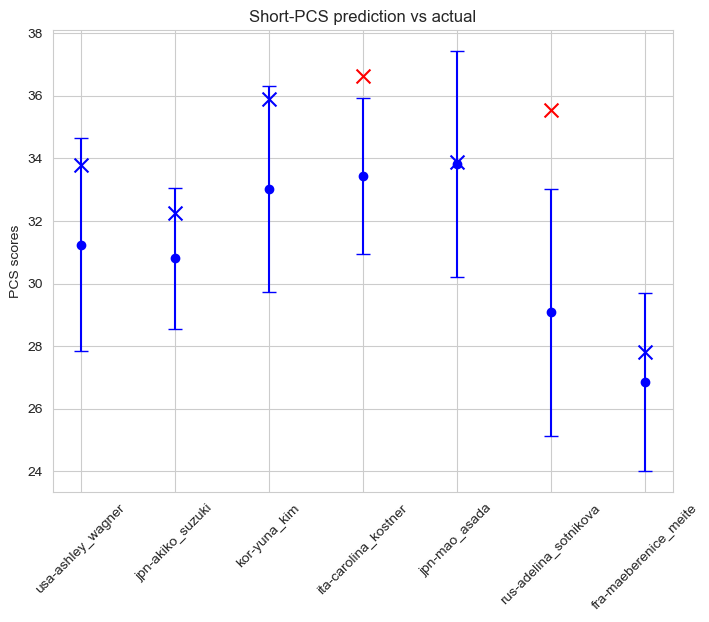

In [303]:
# 쇼트-PCS 그래프
def plot_short_pcs():
    short_df = prediction_df[prediction_df["score_type"] == "short-PCS"]
    plt.figure(figsize=(8, 6))
    for _, row in short_df.iterrows():
        color = "red" if not (row["lower_bound"] <= row["actual"] <= row["upper_bound"]) else "blue"
        plt.errorbar(row["name"], row["predicted"],
                     yerr=[[row["predicted"] - row["lower_bound"]], [row["upper_bound"] - row["predicted"]]],
                     fmt='o', capsize=5, color="blue")
        plt.scatter(row["name"], row["actual"], color=color, marker='x', s=100)
    plt.title("Short-PCS prediction vs actual")
    plt.ylabel("PCS scores")
    plt.xticks(rotation=45)
    plt.show()

plot_short_pcs()

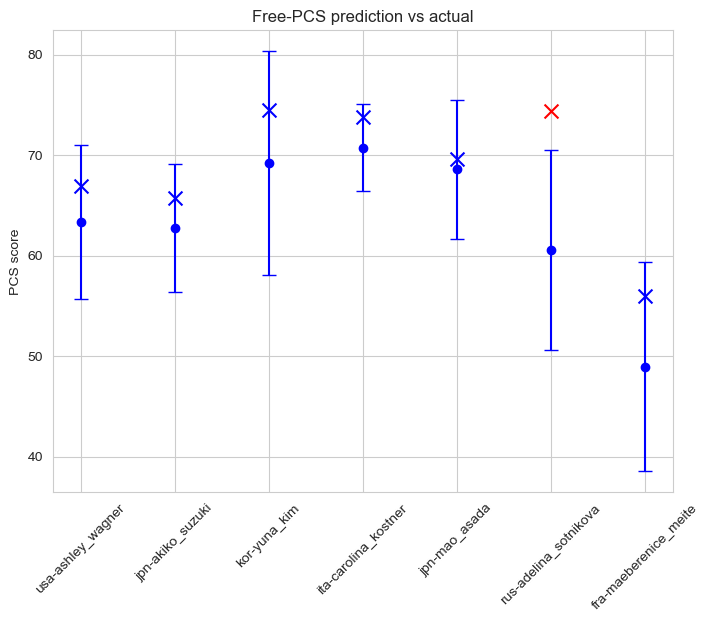

In [305]:
# 프리-PCS 그래프
def plot_free_pcs():
    free_df = prediction_df[prediction_df["score_type"] == "free-PCS"]
    plt.figure(figsize=(8, 6))
    for _, row in free_df.iterrows():
        color = "red" if not (row["lower_bound"] <= row["actual"] <= row["upper_bound"]) else "blue"
        plt.errorbar(row["name"], row["predicted"],
                     yerr=[[row["predicted"] - row["lower_bound"]], [row["upper_bound"] - row["predicted"]]],
                     fmt='o', capsize=5, color="blue")
        plt.scatter(row["name"], row["actual"], color=color, marker='x', s=100)
    plt.title("Free-PCS prediction vs actual")
    plt.ylabel("PCS score")
    plt.xticks(rotation=45)
    plt.show()

plot_free_pcs()